#  Interactions at baits

In this Jupyter notebook, the classes ``BaitedDigest`` and ``BaitedDigestSet`` are demonstrated.

The class ``BaitedDigest`` can be used to group interactions according to the baits in which they end. Within this class, interactions are further differntiated according to interaction category (``DI``, ``UIR``, ``UI`` and ``ALL``) and the enrichment status of the two digests (``NE`` and ``EN``). Interactions with the enrichment state `NN` or ``EE`` cannot be assigned unabgiuously to a baited digests and, therefore, are not taken into account. However, for capture Hi-C data, such interactions make up only a small percentage (around 10% on average).

The class ``BaitedDigestSet`` can be used to manage a number of ``BaitedDigest`` objects. At its core, it is a dictionary in which ``BaitedDigest`` objects are stored, with the coordinates of the digests serving as keys.

This structuring of the data enables properties of interactions that end in the same baited digest to be investigated and compared for the different interaction categories and enrichment states.

## Setting up the notebook

In [1]:
import sys
import os
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import BaitedDigest
from diachr import BaitedDigestSet

## Test file

We have prepared a small test file in ``Diachromatic11`` format (already contains the  interaction categories ``DI``, ``UIR`` and ``UI``) that only contains interactions on chromosome ``chr21`` and ``chr22``.

In [2]:
# Interactions on 'chr21' and 'chr22' only
#INTERACTION_FILE = "../tests/data/baited_digests_d11_interaction_test_file.tsv.gz"

# 100,000 randomly selected interactions
#INTERACTION_FILE = "../tests/data/baited_digests_d11_interaction_test_file_2.tsv.gz"

# Real data without shuffling
#INTERACTION_FILE = "../stair_like_structure_minimal/JAV_MAC_M1_RALT_20000_evaluated_and_categorized_interactions.tsv.gz"

# Real data with shuffling
INTERACTION_FILE = "../stair_like_structure_minimal/JAV_MAC_M1_RALT_RS42_evaluated_and_categorized_interactions.tsv.gz"

## Creation of a ``BaitedDigestSet``

First, we create a ``DiachromaticInteractionSet`` from the test file.

In [3]:
d11_interaction_set = DiachromaticInteractionSet()
d11_interaction_set.parse_file(i_file=INTERACTION_FILE, verbose=True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../stair_like_structure_minimal/JAV_MAC_M1_RALT_RS42_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Set size: 4,581,057
[INFO] ... done.


Next, we create a ``BaitedDigestSet`` and pass the ``DiachromaticInteractionSet``.

In [4]:
baited_digest_set = BaitedDigestSet()
read_interactions_info_dict = baited_digest_set.ingest_interaction_set(d11_interaction_set, verbose=True)

[INFO] Reading interactions and group them according to chromosomes and baited digests ...
	[INFO] Read 1,000,000 interactions ...
	[INFO] Read 2,000,000 interactions ...
	[INFO] Read 3,000,000 interactions ...
	[INFO] Read 4,000,000 interactions ...
	[INFO] Total number of interactions read: 4,581,057
	[INFO] Total number of baited digests: 21,681
[INFO] ... done.


The function ``get_ingest_interaction_set_info_report()`` returns a string with more detailed information on the ingestion.

In [5]:
print(baited_digest_set.get_ingest_interaction_set_info_report())

[INFO] Report on ingestion of interactions:
	[INFO] Total number of interactions read: 4,581,057
	[INFO] Discarded NN and EE interactions: 379,907
	[INFO] Total number of ingested NE and EN interactions: 4,201,150
	[INFO] Broken down by interaction category and enrichment status: 
		[INFO] DI: 
			[INFO] NE: 90,700
			[INFO] EN: 93,315
		[INFO] UIR: 
			[INFO] NE: 90,634
			[INFO] EN: 93,256
		[INFO] UI: 
			[INFO] NE: 1,920,279
			[INFO] EN: 1,912,966
		[INFO] ALL: 
			[INFO] NE: 2,101,613
			[INFO] EN: 2,099,537
	[INFO] Total number of baited digests: 21,681
[INFO] End of report.



And the function ``get_ingest_interaction_set_table_row()`` returns the same information in table format.

In [6]:
print(baited_digest_set.get_ingest_interaction_set_table_row())

:TR_INGESTION:	TOTAL_INTERACTIONS_READ	DISCARDED	INGESTED	DI_NE	DI_EN	UIR_NE	UIR_EN	UI_NE	UI_EN	ALL_NE	ALL_EN	BAITED_DIGESTS
:TR_INGESTION:	4581057	379907	4201150	90700	93315	90634	93256	1920279	1912966	2101613	2099537	21681



### Explanation of the data structure

In the object ``baited_digest_set``, the chromosomes are first grouped according to chromosomes. For example, ``baited_digest_set._baited_digest_dict['chr21']`` all ``BaitedDigest`` object that were created for ``chr21``.

In [7]:
dict_all_baited_digest_objects_on_chr21 = baited_digest_set._baited_digest_dict['chr21']

A individual ``BaitedDigest`` object can be aaccessed via its digest coordinates.

In [8]:
individual_baited_digest_object_on_chr21 = baited_digest_set._baited_digest_dict['chr21']['chr21\t33167499\t33175012']

An ``BaitedDigest``, contains all interactions that end in this digest, spearted by interaction category and enrichment status. Here, as an example, an interaction of category ``DI`` with enricchment state ``NE``.

In [9]:
baited_digest_set._baited_digest_dict['chr21']['chr21\t33167499\t33175012'].interactions['DI']['NE'][0].get_category()

'DI'

In [10]:
baited_digest_set._baited_digest_dict['chr21']['chr21\t33167499\t33175012'].interactions['DI']['NE'][0].enrichment_status_tag_pair

'NE'

## Number pairs at baits ``(NE, EN)``

The data structure with the ``BaitedDigest`` makes it easy to calculate number pairs ``(NE,EN)``  for each bait. We have determined number pairs of the following types:

1. Interaction numbers
2. Read pair numbers
3. Median distances

In [1]:
import sys
import os
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import BaitedDigest
from diachr import BaitedDigestSet


#INTERACTION_FILE = "../stair_like_structure_minimal/shuff_rev/JAV_MAC_M1_RALT_CHR22_evaluated_and_categorized_interactions.tsv.gz"
#INTERACTION_FILE = "../stair_like_structure_minimal/shuff_rev/JAV_MAC_M1_RALT_CHR22_REV_evaluated_and_categorized_interactions.tsv.gz"
INTERACTION_FILE = "../stair_like_structure_minimal/shuff_rev/JAV_MAC_M1_RALT_CHR22_SHUFF_evaluated_and_categorized_interactions.tsv.gz"

#INTERACTION_FILE = "../stair_like_structure_minimal/JAV_MAC_M1_RALT_20000_evaluated_and_categorized_interactions.tsv.gz"
#INTERACTION_FILE = "../stair_like_structure_minimal/shuff_rev/JAV_MAC_M1_RALT_SHUFF_evaluated_and_categorized_interactions.tsv.gz"


d11_interaction_set = DiachromaticInteractionSet()
d11_interaction_set.parse_file(i_file=INTERACTION_FILE, verbose=True)
baited_digest_set = BaitedDigestSet()
read_interactions_info_dict = baited_digest_set.ingest_interaction_set(d11_interaction_set, verbose=True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../stair_like_structure_minimal/shuff_rev/JAV_MAC_M1_RALT_CHR22_SHUFF_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Set size: 61,044
[INFO] ... done.
[INFO] Reading interactions and group them according to chromosomes and baited digests ...
	[INFO] Total number of interactions read: 61,044
	[INFO] Total number of baited digests: 418
[INFO] ... done.


In [2]:
#baited_digest_set.select_undirected_reference_interactions_at_baits(0.25, 0.75)
baited_digest_set.select_undirected_reference_interactions_at_baits(0.50, 0.75)
#baited_digest_set.select_undirected_reference_interactions_at_baits(0.50, 1.00)
#baited_digest_set.select_undirected_reference_interactions_at_baits(0.75, 1.00)

-------
Number of DI: 3
DI read pair numbers: [13, 14, 94]
Upper quantile: 14.0
Lower quantile: 54.0
Median read pair number DI: 14.0
Median read pair number UIR-NE: 19.0
Median read pair number UIR-EN: 22.5
-------
Number of DI: 17
DI read pair numbers: [13, 15, 16, 18, 18, 20, 22, 32, 55, 62, 62, 64, 72, 78, 81, 95, 119]
Upper quantile: 55.0
Lower quantile: 72.0
Median read pair number DI: 55.0
Median read pair number UIR-NE: 69.0
NA
-------
Number of DI: 0
DI read pair numbers: []
Upper quantile: 0.0
Lower quantile: 0.0
NA
NA
NA
-------
Number of DI: 1
DI read pair numbers: [268]
Upper quantile: 268.0
Lower quantile: 268.0
Median read pair number DI: 268.0
NA
NA
-------
Number of DI: 7
DI read pair numbers: [11, 20, 24, 29, 35, 96, 165]
Upper quantile: 29.0
Lower quantile: 65.5
Median read pair number DI: 29.0
Median read pair number UIR-NE: 45.5
Median read pair number UIR-EN: 34.0
-------
Number of DI: 3
DI read pair numbers: [66, 83, 97]
Upper quantile: 83.0
Lower quantile: 90.0


-------
Number of DI: 10
DI read pair numbers: [17, 30, 45, 46, 47, 66, 68, 83, 123, 268]
Upper quantile: 56.5
Lower quantile: 79.25
Median read pair number DI: 56.5
Median read pair number UIR-NE: 62.0
Median read pair number UIR-EN: 59.5
-------
Number of DI: 10
DI read pair numbers: [13, 17, 20, 24, 30, 38, 43, 47, 58, 78]
Upper quantile: 34.0
Lower quantile: 46.0
Median read pair number DI: 34.0
Median read pair number UIR-NE: 41.5
Median read pair number UIR-EN: 41.5
-------
Number of DI: 16
DI read pair numbers: [12, 14, 15, 18, 22, 24, 26, 53, 70, 85, 88, 93, 102, 123, 128, 130]
Upper quantile: 61.5
Lower quantile: 95.25
Median read pair number DI: 61.5
NA
Median read pair number UIR-EN: 81.0
-------
Number of DI: 1
DI read pair numbers: [214]
Upper quantile: 214.0
Lower quantile: 214.0
Median read pair number DI: 214.0
NA
NA
-------
Number of DI: 7
DI read pair numbers: [22, 22, 41, 156, 170, 177, 194]
Upper quantile: 156.0
Lower quantile: 173.5
Median read pair number DI: 156.

-------
Number of DI: 1
DI read pair numbers: [165]
Upper quantile: 165.0
Lower quantile: 165.0
Median read pair number DI: 165.0
NA
NA
-------
Number of DI: 1
DI read pair numbers: [27]
Upper quantile: 27.0
Lower quantile: 27.0
Median read pair number DI: 27.0
NA
NA
-------
Number of DI: 6
DI read pair numbers: [47, 49, 83, 91, 143, 155]
Upper quantile: 87.0
Lower quantile: 130.0
Median read pair number DI: 87.0
Median read pair number UIR-NE: 101.5
Median read pair number UIR-EN: 125.0
-------
Number of DI: 4
DI read pair numbers: [45, 45, 61, 96]
Upper quantile: 53.0
Lower quantile: 69.75
Median read pair number DI: 53.0
Median read pair number UIR-NE: 61.0
NA
-------
Number of DI: 20
DI read pair numbers: [11, 13, 15, 16, 23, 24, 26, 29, 30, 38, 39, 39, 53, 58, 68, 70, 84, 91, 98, 123]
Upper quantile: 38.5
Lower quantile: 68.5
Median read pair number DI: 38.5
Median read pair number UIR-NE: 58.5
NA
-------
Number of DI: 5
DI read pair numbers: [14, 62, 70, 71, 152]
Upper quantile: 

In [3]:
rp_num_dict = baited_digest_set.get_all_rp_nums_or_i_dists(
    number_type = 'RP_NUM',
    #chromosomes=['chr21', 'chr22'],
    verbose=True
)

[INFO] Getting all read pair numbers ...
	[INFO] Processing chromosome chr22 ...
[INFO] ... done.


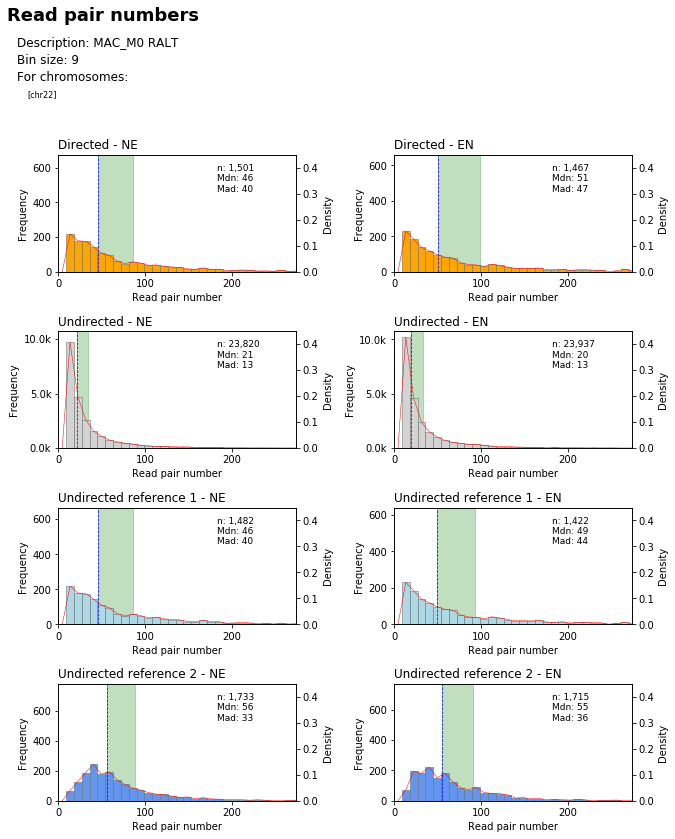

In [5]:
fig = baited_digest_set.get_all_rp_nums_or_i_dists_histograms(
    num_dict = rp_num_dict,
    #q_lim = 1.00,
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_read_pair_number_histograms.pdf'
)

In [6]:
id_dict = baited_digest_set.get_all_rp_nums_or_i_dists(
    number_type = 'I_DIST',
    #chromosomes=['chr21', 'chr22'],
    verbose=True
)

[INFO] Getting all interaction distances ...
	[INFO] Processing chromosome chr22 ...
[INFO] ... done.


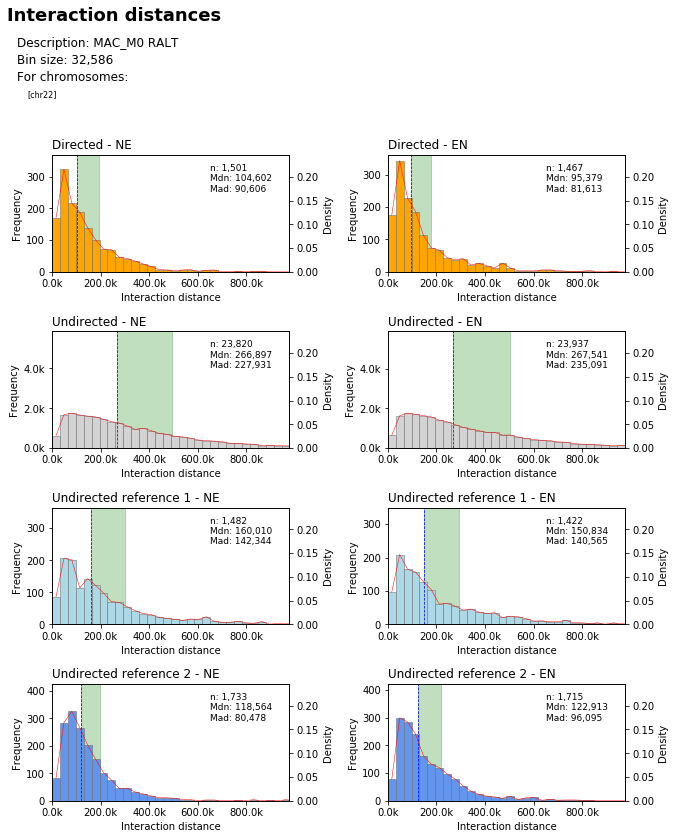

In [7]:
fig = baited_digest_set.get_all_rp_nums_or_i_dists_histograms(
    num_dict = id_dict,
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_interaction_distance_histograms.pdf'
)

## Density difference plot

In [1]:
import sys
import os
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import BaitedDigest
from diachr import BaitedDigestSet


#INTERACTION_FILE = "../stair_like_structure_minimal/shuff_rev/JAV_MAC_M1_RALT_CHR22_evaluated_and_categorized_interactions.tsv.gz"
#INTERACTION_FILE = "../stair_like_structure_minimal/shuff_rev/JAV_MAC_M1_RALT_CHR22_REV_evaluated_and_categorized_interactions.tsv.gz"
INTERACTION_FILE = "../stair_like_structure_minimal/shuff_rev/JAV_MAC_M1_RALT_CHR22_SHUFF_evaluated_and_categorized_interactions.tsv.gz"

#INTERACTION_FILE = "../stair_like_structure_minimal/JAV_MAC_M1_RALT_20000_evaluated_and_categorized_interactions.tsv.gz"
#INTERACTION_FILE = "../stair_like_structure_minimal/shuff_rev/JAV_MAC_M1_RALT_SHUFF_evaluated_and_categorized_interactions.tsv.gz"

d11_interaction_set = DiachromaticInteractionSet()
d11_interaction_set.parse_file(i_file=INTERACTION_FILE, verbose=True)
baited_digest_set = BaitedDigestSet()
read_interactions_info_dict = baited_digest_set.ingest_interaction_set(d11_interaction_set, verbose=True)
#baited_digest_set.select_undirected_reference_interactions_at_baits(0.50, 0.75)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../stair_like_structure_minimal/shuff_rev/JAV_MAC_M1_RALT_CHR22_SHUFF_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Set size: 61,044
[INFO] ... done.
[INFO] Reading interactions and group them according to chromosomes and baited digests ...
	[INFO] Total number of interactions read: 61,044
	[INFO] Total number of baited digests: 418
[INFO] ... done.


In [2]:
id_dict = baited_digest_set.get_all_rp_nums_or_i_dists(
    number_type = 'I_DIST',
    #chromosomes=['chr21', 'chr22'],
    verbose=True
)

[INFO] Getting all interaction distances ...
	[INFO] Processing chromosome chr22 ...
[INFO] ... done.


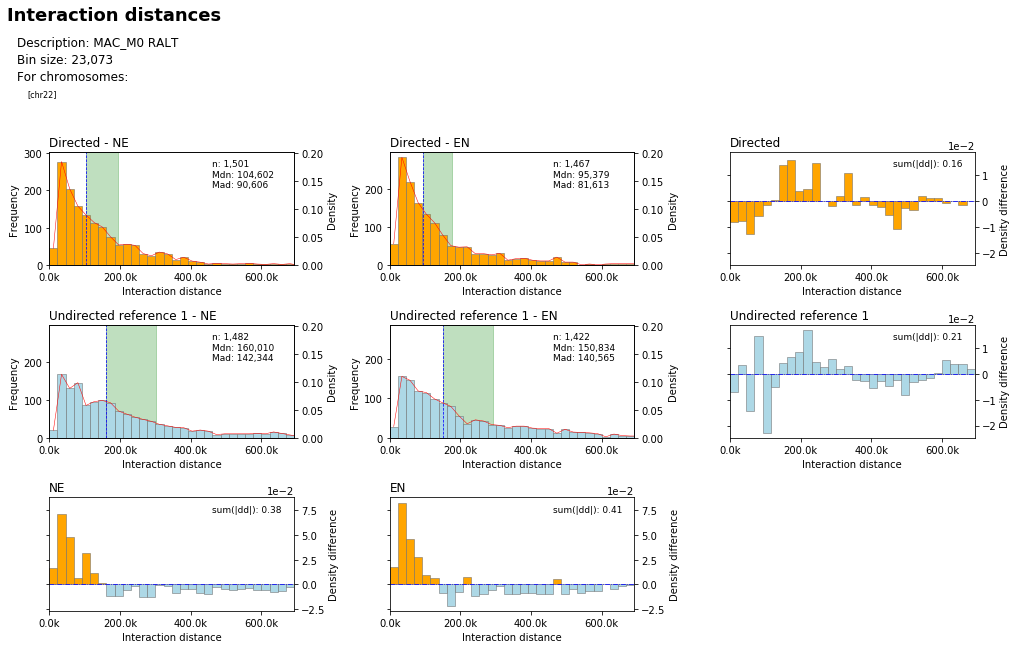

In [3]:
fig = baited_digest_set.get_all_rp_nums_or_i_dists_denisty_diff_plot(
    num_dict = id_dict,
    i_cats = ['DI', 'UIR'],
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_interaction_distance_densitity_diff_plot_DI-UIR.pdf'
)

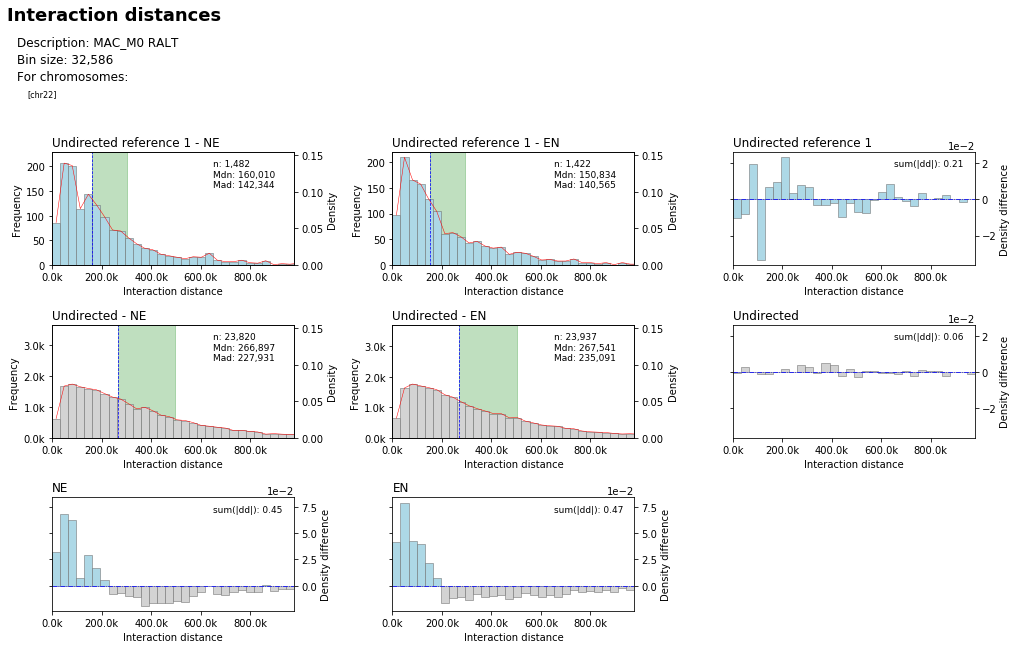

In [4]:
fig = baited_digest_set.get_all_rp_nums_or_i_dists_denisty_diff_plot(
    num_dict = id_dict,
    i_cats = ['UIR', 'UI'],
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_interaction_distance_densitity_diff_plot_UIR-UI.pdf'
)

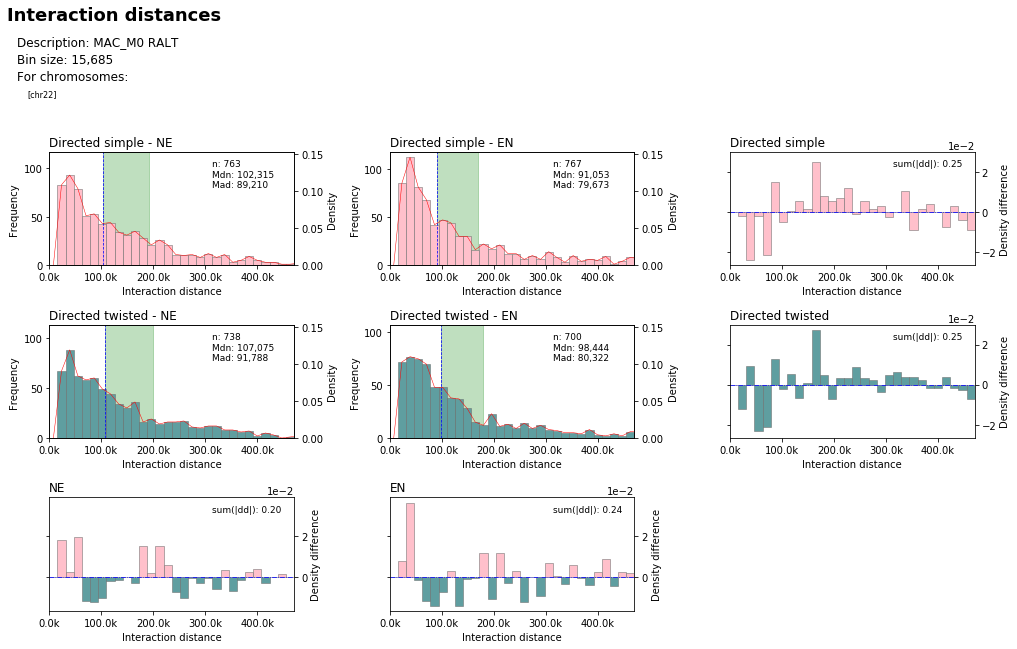

In [5]:
fig = baited_digest_set.get_all_rp_nums_or_i_dists_denisty_diff_plot(
    num_dict = id_dict,
    i_cats = ['DI_S', 'DI_T'],
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_interaction_distance_densitity_diff_plot_DI_S-DI_T.pdf'
)

In [6]:
rp_dict = baited_digest_set.get_all_rp_nums_or_i_dists(
    number_type = 'RP_NUM',
    #chromosomes=['chr21', 'chr22'],
    verbose=True
)

[INFO] Getting all read pair numbers ...
	[INFO] Processing chromosome chr22 ...
[INFO] ... done.


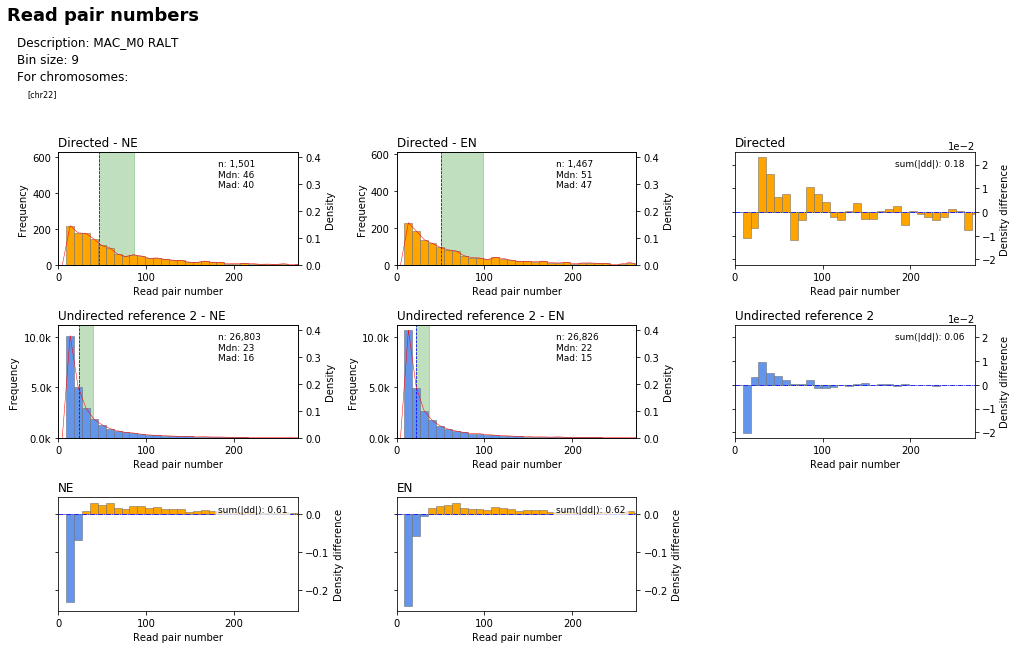

In [7]:
fig = baited_digest_set.get_all_rp_nums_or_i_dists_denisty_diff_plot(
    num_dict = rp_dict,
    i_cats = ['DI', 'ALL'],
    #q_lim = 1.00,
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_read_pair_densitity_diff_plot.pdf'
)

## Interaction BED files

In [36]:
baited_digest_set.write_bed_files_with_baited_interactions(
    out_prefix = 'bed_files/MAC_M1_RALT_CHR5_SHUFF',
    chromosomes=['chr5'])

### Interaction number pairs

#### Determination of number pairs

The function ``baited_digest_set.get_number_pairs_at_baits()`` can be used to determine number pairs of all types. In order to determine pairs of interaction numbers, the function must be called with the argument ``number_pair_type='I_NUM'``. In addition, the analysis can be restricted to subsets of chromosomes by passing a list with the corresponding chromosome names.

The results are returned in form of a dictionary, which contains the number pairs, separated according to the different interaction categories. Furthermore, the dictionary contains a list of chromosomes that have been taken into account, the associated number of baits, and the type of the pairs (use ``i_num_pair_dict.keys()`` to explore the dictionary).

In [8]:
i_num_pair_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='I_NUM',
    #chromosomes=['chr21', 'chr22'],
    verbose=True
)

[INFO] Determining pairs of interaction numbers (to the left and right) at baits ...
	[INFO] Processing chromosome chr22 ...
[INFO] ... done.


#### Graphical representation of number pairs

The function ``get_pair_scatter_plots_with_histograms()`` can be used to graphically represent number pairs of any type. To do this, the previously created dictionary with the number pairs is passed to this function. In adddition, two text fields can be set and the name of the PDF file to which the plot will be written can be specified. There are two other function paramenters that are explained below along with the plot.

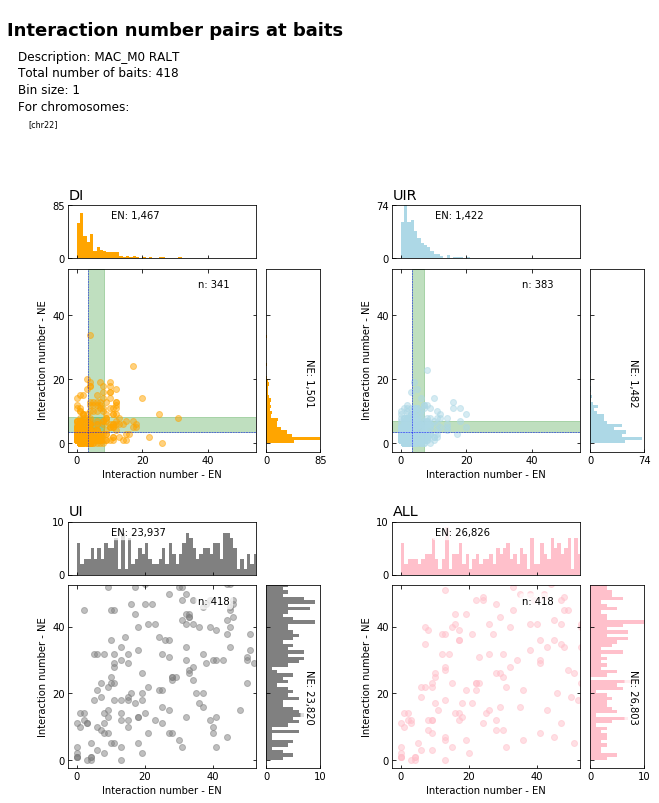

In [9]:
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = i_num_pair_dict,
    draw_mean_and_sd = True,
    #set_xy_max = 100,
    set_xy_max = 50,
    sup_title = 'Interaction number pairs at baits',
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_i_num_pairs_scatter_plots_with_histograms.pdf'
)

### Read pair number pairs

In [43]:
rp_num_pairs_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='RP_NUM',
    #chromosomes=['chr22']
    verbose = True
)

[INFO] Determining pairs of read pair numbers (to the left and right) at baits ...
	[INFO] Processing chromosome chr11 ...
	[INFO] Processing chromosome chr15 ...
	[INFO] Processing chromosome chr6 ...
	[INFO] Processing chromosome chr5 ...
	[INFO] Processing chromosome chr13 ...
	[INFO] Processing chromosome chr2 ...
	[INFO] Processing chromosome chr8 ...
	[INFO] Processing chromosome chrX ...
	[INFO] Processing chromosome chr22 ...
	[INFO] Processing chromosome chr7 ...
	[INFO] Processing chromosome chr10 ...
	[INFO] Processing chromosome chr1 ...
	[INFO] Processing chromosome chr18 ...
	[INFO] Processing chromosome chr19 ...
	[INFO] Processing chromosome chr17 ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr4 ...
	[INFO] Processing chromosome chr12 ...
	[INFO] Processing chromosome chr9 ...
	[INFO] Processing chromosome chr14 ...
	[INFO] Processing chromosome chr3 ...
	[INFO] Processing chromosome chr20 ...
	[INFO] Processing chromosome chr16 ...
	[INFO]

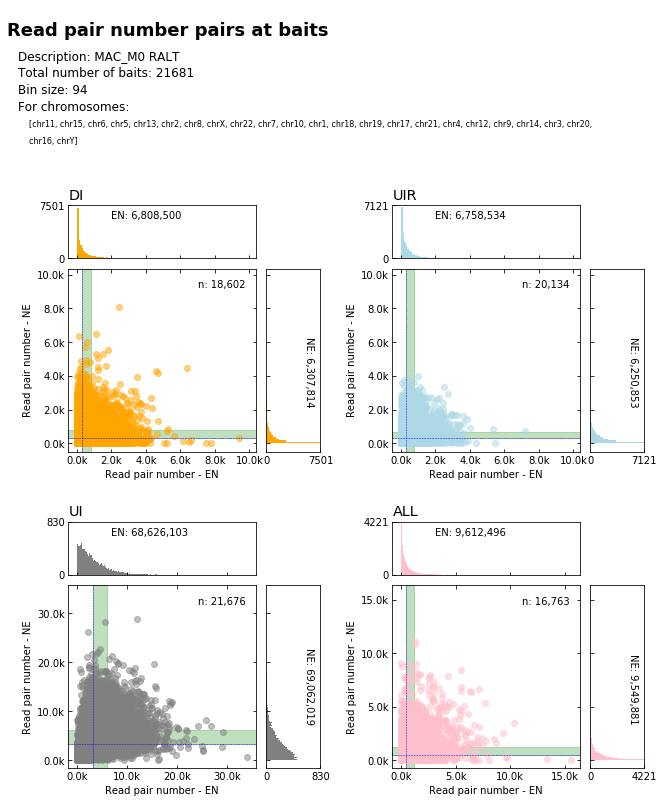

In [44]:
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = rp_num_pairs_dict,
    draw_mean_and_sd=True,
    #set_xy_max = 500,
    #set_xy_max = 150,
    sup_title = 'Read pair number pairs at baits',
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_rp_num_pairs_scatter_plots_with_histograms.pdf')

### Median read pair number pairs

In [30]:
med_rp_num_pairs_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='MED_RP_NUM',
    #chromosomes=['chr22']
    verbose = True
)

[INFO] Determining pairs of median read pair numbers (to the left and right) at baits ...
	[INFO] Processing chromosome chr11 ...
	[INFO] Processing chromosome chr15 ...
	[INFO] Processing chromosome chr6 ...
	[INFO] Processing chromosome chr5 ...
	[INFO] Processing chromosome chr13 ...
	[INFO] Processing chromosome chr2 ...
	[INFO] Processing chromosome chr8 ...
	[INFO] Processing chromosome chrX ...
	[INFO] Processing chromosome chr22 ...
	[INFO] Processing chromosome chr7 ...
	[INFO] Processing chromosome chr10 ...
	[INFO] Processing chromosome chr1 ...
	[INFO] Processing chromosome chr18 ...
	[INFO] Processing chromosome chr19 ...
	[INFO] Processing chromosome chr17 ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr4 ...
	[INFO] Processing chromosome chr12 ...
	[INFO] Processing chromosome chr9 ...
	[INFO] Processing chromosome chr14 ...
	[INFO] Processing chromosome chr3 ...
	[INFO] Processing chromosome chr20 ...
	[INFO] Processing chromosome chr16 ...


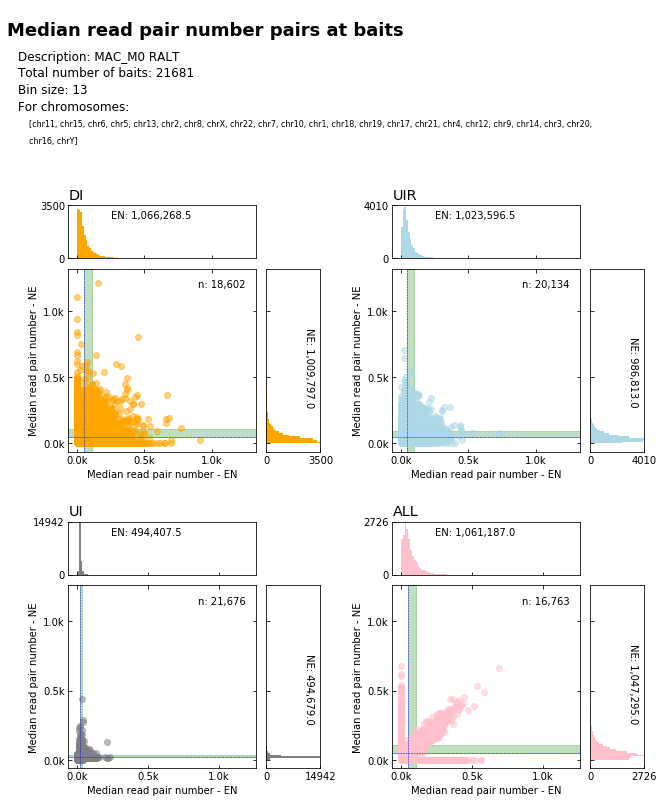

In [31]:
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = med_rp_num_pairs_dict,
    draw_mean_and_sd=True,
    set_xy_max = 1200,
    #set_xy_max = 150,
    sup_title = 'Median read pair number pairs at baits',
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_med_rp_num_pairs_scatter_plots_with_histograms.pdf')

### Median distance pairs

In [48]:
med_i_dist_pair_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='MED_I_DIST',
    #chromosomes=['chr22'],
    verbose = True
)

[INFO] Determining pairs of median interaction distances (to the left and right) at baits ...
	[INFO] Processing chromosome chr11 ...
	[INFO] Processing chromosome chr15 ...
	[INFO] Processing chromosome chr6 ...
	[INFO] Processing chromosome chr5 ...
	[INFO] Processing chromosome chr13 ...
	[INFO] Processing chromosome chr2 ...
	[INFO] Processing chromosome chr8 ...
	[INFO] Processing chromosome chrX ...
	[INFO] Processing chromosome chr22 ...
	[INFO] Processing chromosome chr7 ...
	[INFO] Processing chromosome chr10 ...
	[INFO] Processing chromosome chr1 ...
	[INFO] Processing chromosome chr18 ...
	[INFO] Processing chromosome chr19 ...
	[INFO] Processing chromosome chr17 ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr4 ...
	[INFO] Processing chromosome chr12 ...
	[INFO] Processing chromosome chr9 ...
	[INFO] Processing chromosome chr14 ...
	[INFO] Processing chromosome chr3 ...
	[INFO] Processing chromosome chr20 ...
	[INFO] Processing chromosome chr16 

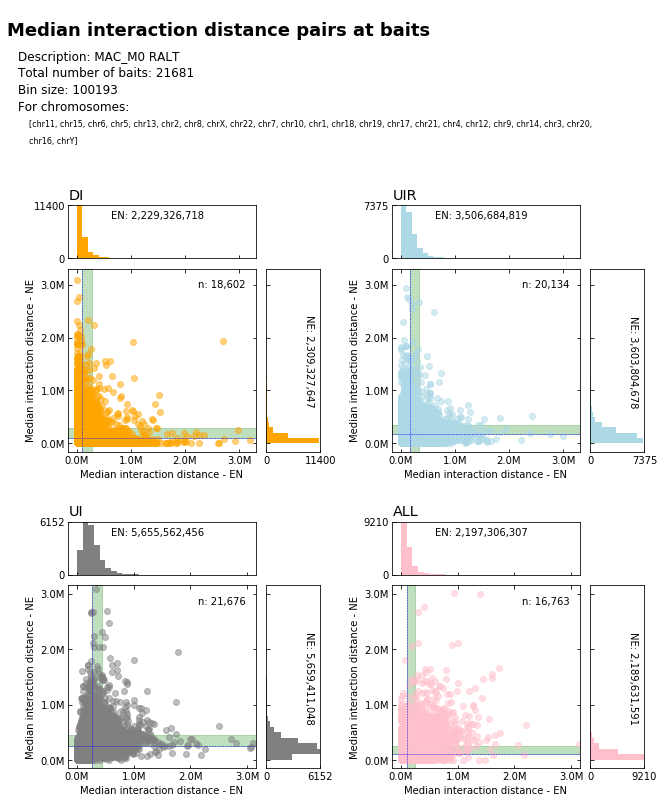

In [52]:
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = med_i_dist_pair_dict,
    draw_mean_and_sd=True,
    set_xy_max = 3000000,
    #set_xy_max = 400000,
    sup_title = 'Median interaction distance pairs at baits',
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_med_i_dist_pairs_scatter_plots_with_histograms.pdf')

## Proportion of directed interactions on individual chromosomes

In [35]:
baited_digest_set.proportion_of_directed_interactions_on_individual_chromosomes()

1389
chr11	43226	11133	0.26	0.26	0.48	0.49
621
chr15	20927	5489	0.26	0.27	0.49	0.5
1193
chr6	49012	10830	0.22	0.24	0.5	0.5
1106
chr5	46652	9911	0.21	0.25	0.52	0.5
443
chr13	20586	3893	0.19	0.23	0.51	0.5
1586
chr2	68235	14702	0.22	0.23	0.49	0.49
886
chr8	37463	7999	0.21	0.24	0.49	0.49
821
chrX	11795	3073	0.26	0.28	0.51	0.49
418
chr22	8204	2968	0.36	0.29	0.51	0.48
1001
chr7	39380	8514	0.22	0.22	0.5	0.48
916
chr10	34323	8518	0.25	0.25	0.51	0.49
2223
chr1	76984	19971	0.26	0.25	0.49	0.49
349
chr18	16218	3430	0.21	0.22	0.5	0.49
1013
chr19	13703	6357	0.46	0.24	0.49	0.5
1041
chr17	23600	8789	0.37	0.28	0.49	0.5
262
chr21	8732	2093	0.24	0.27	0.48	0.47
935
chr4	44225	8873	0.2	0.22	0.49	0.5
1186
chr12	42973	11251	0.26	0.23	0.48	0.48
854
chr9	30832	7697	0.25	0.25	0.49	0.49
768
chr14	27488	6331	0.23	0.25	0.49	0.48
1325
chr3	53265	12171	0.23	0.25	0.49	0.49
614
chr20	17911	4699	0.26	0.25	0.5	0.49
711
chr16	16403	5191	0.32	0.24	0.49	0.49
20
chrY	481	132	0.27	0.09	0.39	0.44


## BaitedDigest key sorted by starting position

In [3]:
sorted_baited_digest_keys = baited_digest_set.get_baited_digest_keys_sorted_by_sta_pos()
for i in sorted_baited_digest_keys['chr1']:
    print(i)

chr1	100000550	100006894
chr1	100036777	100043714
chr1	100131278	100133109
chr1	100133110	100142084
chr1	100168796	100181433
chr1	10025454	10034144
chr1	100260701	100272506
chr1	100272507	100282683
chr1	100337220	100346551
chr1	100373119	100379786
chr1	100485685	100493194
chr1	100534969	100543182
chr1	100719454	100720479
chr1	1008297	1021819
chr1	100895342	100897499
chr1	100995306	100995724
chr1	101024918	101028682
chr1	101130826	101136757
chr1	10160976	10166404
chr1	101855943	101861664
chr1	10192130	10213010
chr1	101995913	101997833
chr1	10295530	10302317
chr1	103107738	103113649
chr1	103522215	103529871
chr1	103550983	103557785
chr1	10385312	10400963
chr1	10429417	10433971
chr1	10433972	10449962
chr1	10457726	10459528
chr1	10471160	10475570
chr1	10671631	10684323
chr1	10690980	10707459
chr1	1069747	1098888
chr1	107054408	107056737
chr1	107136718	107142739
chr1	10721167	10727517
chr1	107445670	107449569
chr1	107565338	107574607
chr1	10784330	10799862
chr1	107955005	107964460
chr1	1079

# Shuffle ``diachromatic_interaction_set._inter_dict``

Input files may be affected by sorting artifacts. When the files are read in, such artifacts are transferred to the dictionary with interactions in ``DiachromaticInteractionSet``. The function ``d_interaction_set.shuffle_inter_dict()`` can be used to shuffle the key-value pairs after interactions have been read. In this way, such artifact are eliminated.

We import the module ``DiachromaticInteractionSet``.

In [1]:
import sys
import os
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet

We read a file with only four interactions.

In [2]:
INTERACTION_FILE = "../tests/data/test_01/diachromatic_interaction_file_r4.tsv.gz"
d_interaction_set = DiachromaticInteractionSet()
d_interaction_set.parse_file(i_file=INTERACTION_FILE, verbose=True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_01/diachromatic_interaction_file_r4.tsv.gz
	[INFO] Set size: 4
[INFO] ... done.


We output the key-value pairs from the dictionary.

In [3]:
for key, value in d_interaction_set._inter_dict.items():
    print(key + '\t' + str(value))

1:46297999:1:51777391	<diachr.diachromatic_interaction.DiachromaticInteraction object at 0xa18692950>
17:72411026:17:72712662	<diachr.diachromatic_interaction.DiachromaticInteraction object at 0x1074ed950>
7:69513952:7:87057837	<diachr.diachromatic_interaction.DiachromaticInteraction object at 0x1074eddd0>
11:47259263:11:91641153	<diachr.diachromatic_interaction.DiachromaticInteraction object at 0x1074edfd0>


We use the function ``d_interaction_set.shuffle_inter_dict()`` to shuffle the key-value pairs in the dictionary and output the pairs again.

In [14]:
INTERACTION_FILE = "../tests/data/test_01/diachromatic_interaction_file_r4.tsv.gz"
d_interaction_set = DiachromaticInteractionSet()
d_interaction_set.parse_file(i_file=INTERACTION_FILE, verbose=True)
d_interaction_set.shuffle_inter_dict(11)
for key, value in d_interaction_set._inter_dict.items():
    print(key + '\t' + str(value))

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_01/diachromatic_interaction_file_r4.tsv.gz
	[INFO] Set size: 4
[INFO] ... done.
1:46297999:1:51777391	<diachr.diachromatic_interaction.DiachromaticInteraction object at 0x1a1cfb5810>
17:72411026:17:72712662	<diachr.diachromatic_interaction.DiachromaticInteraction object at 0x1a1cfa4d10>
7:69513952:7:87057837	<diachr.diachromatic_interaction.DiachromaticInteraction object at 0x1a1cfa4e50>
11:47259263:11:91641153	<diachr.diachromatic_interaction.DiachromaticInteraction object at 0x1a1cfa4c50>


In [23]:
INTERACTION_FILE = "../stair_like_structure_minimal/JAV_MAC_M1_RALT_20000_evaluated_and_categorized_interactions.tsv.gz"
d_interaction_set = DiachromaticInteractionSet()
d_interaction_set.parse_file(i_file=INTERACTION_FILE, verbose=True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../stair_like_structure_minimal/JAV_MAC_M1_RALT_20000_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Set size: 4,581,057
[INFO] ... done.


In [24]:
d_interaction_set.shuffle_inter_dict(verbose=True)

[INFO] Shuffling dictionary with interactions ...
[INFO] ... done.
